In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import Counter

In [2]:
user_data = pd.read_csv('user_data.csv')
user_data.head()

,CustomerID,purchase_cnt,item_cnt,recency,user_total,user_average,unique_products,average_interval,total_transactions,cancel_frequency,cancel_rate
0,16765,1,4,294,34.0,34.0,1,0.0,1,0,0.0
1,16148,1,72,296,76.3,76.3,1,0.0,1,0,0.0
2,15510,1,2,330,250.0,250.0,1,0.0,1,0,0.0
3,14576,1,12,372,35.4,35.4,1,0.0,1,0,0.0
4,14424,1,48,17,322.1,322.1,1,0.0,1,0,0.0


# 1. 이상 데이터 분석 및 처리

In [3]:
z_scores = stats.zscore(user_data)
z_scores = np.abs(z_scores)
z_scores

array([[8.50825288e-01, 3.96910512e-01, 2.38483026e-01, ...,
        3.96910512e-01, 2.71913268e-01, 2.96535930e-01],
       [4.92432305e-01, 3.96910512e-01, 2.23917546e-01, ...,
        3.96910512e-01, 2.71913268e-01, 2.96535930e-01],
       [1.21841182e-01, 3.96910512e-01, 2.38911423e-01, ...,
        3.96910512e-01, 2.71913268e-01, 2.96535930e-01],
       ...,
       [6.24927984e-03, 1.04542264e+01, 7.83015045e+00, ...,
        1.04542264e+01, 1.53473220e+01, 1.61296739e-01],
       [1.47583477e+00, 3.37686192e+01, 4.60432497e+00, ...,
        3.37686192e+01, 1.82759286e+01, 1.23814153e-01],
       [2.26096252e-01, 2.50333883e+01, 1.62160115e+01, ...,
        2.50333883e+01, 3.06876423e+01, 9.07805725e-02]])

In [4]:
# 임곗값 설정
threshold = 3

# z-score 기준으로 이상치를 찾아서 outlier 컬럼에 이상치 여부 기입 (0: 정상, 1: 이상치)
user_data['outlier'] = (z_scores > threshold).any(axis=1).astype(int)
user_data.head()


,CustomerID,purchase_cnt,item_cnt,recency,user_total,user_average,unique_products,average_interval,total_transactions,cancel_frequency,cancel_rate,outlier
0,16765,1,4,294,34.0,34.0,1,0.0,1,0,0.0,0
1,16148,1,72,296,76.3,76.3,1,0.0,1,0,0.0,0
2,15510,1,2,330,250.0,250.0,1,0.0,1,0,0.0,0
3,14576,1,12,372,35.4,35.4,1,0.0,1,0,0.0,0
4,14424,1,48,17,322.1,322.1,1,0.0,1,0,0.0,0


C:\Users\songj\AppData\Local\Temp\ipykernel_20300\1711202374.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  outlier_percentage = pd.value_counts(user_data['outlier'], normalize=True) * 100


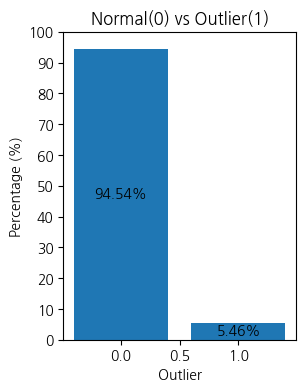

In [5]:
outlier_percentage = pd.value_counts(user_data['outlier'], normalize=True) * 100
plt.figure(figsize=(3,4))
bars=plt.bar([0,1], outlier_percentage)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval/2, f'{yval:.2f}%', fontsize=10, va='center', ha='center')
plt.title('Normal(0) vs Outlier(1)') # 표 제목
plt.yticks(ticks=np.arange(0, 101, 10)) # y축 표기 (0~100까지 10단위로 증가)
plt.ylabel('Percentage (%)') # y축 범례
plt.xlabel('Outlier') # x축 범례
plt.show() # 출력

In [6]:
user_data = user_data[user_data['outlier']==0]
user_data = user_data.drop(columns=['outlier'])
user_data.reset_index(drop=True, inplace=True)
user_data.head()

,CustomerID,purchase_cnt,item_cnt,recency,user_total,user_average,unique_products,average_interval,total_transactions,cancel_frequency,cancel_rate
0,16765,1,4,294,34.0,34.0,1,0.0,1,0,0.0
1,16148,1,72,296,76.3,76.3,1,0.0,1,0,0.0
2,15510,1,2,330,250.0,250.0,1,0.0,1,0,0.0
3,14576,1,12,372,35.4,35.4,1,0.0,1,0,0.0
4,14424,1,48,17,322.1,322.1,1,0.0,1,0,0.0


# 2. 변수 간 상관관계 분석

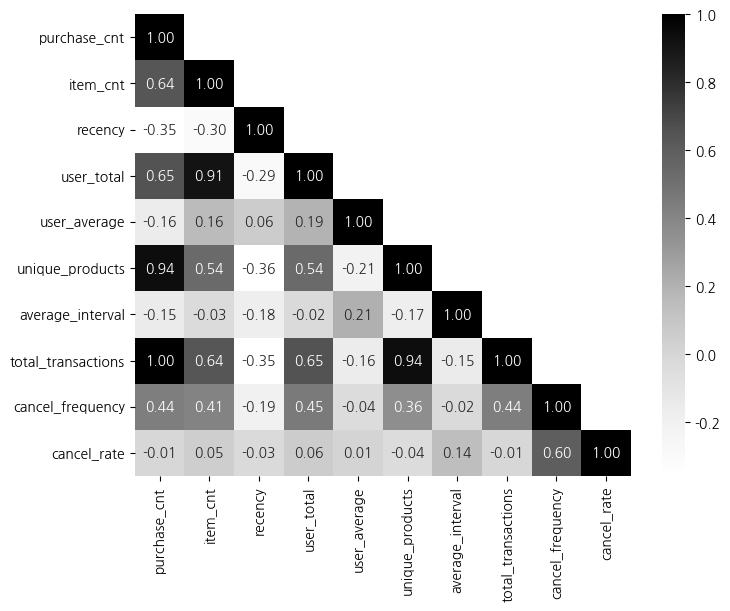

In [8]:
corr = user_data.drop(columns=['CustomerID']).corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(8,6))
sns.heatmap(corr, mask=mask, cmap='Greys', annot=True, fmt='.2f')
plt.show()


In [10]:
scaler = StandardScaler()

data = user_data.copy()
columns_list = data.iloc[:, 1:].columns # iloc: 데이터 특정 값 추출, columns: 데이터프레임의 열 이름 조회 
data[columns_list] = scaler.fit_transform(data[columns_list])

In [11]:
data.head()

,CustomerID,purchase_cnt,item_cnt,recency,user_total,user_average,unique_products,average_interval,total_transactions,cancel_frequency,cancel_rate
0,16765,-0.810174,-0.653635,2.021937,-0.639875,0.219939,-0.961986,-0.577561,-0.810174,-0.428276,-0.44304
1,16148,-0.810174,-0.595364,2.041971,-0.618280,1.266343,-0.961986,-0.577561,-0.810174,-0.428276,-0.44304
2,15510,-0.810174,-0.655348,2.382541,-0.529605,5.563281,-0.961986,-0.577561,-0.810174,-0.428276,-0.44304
3,14576,-0.810174,-0.646779,2.803245,-0.639160,0.254571,-0.961986,-0.577561,-0.810174,-0.428276,-0.44304
4,14424,-0.810174,-0.615930,-0.752708,-0.492797,7.346869,-0.961986,-0.577561,-0.810174,-0.428276,-0.44304


# 3. 피쳐 스케일링

In [13]:
# PCA 불러오기  
from sklearn.decomposition import PCA

# CustomerID를 인덱스로 지정  
data.set_index('CustomerID', inplace=True)

# PCA 적용
pca = PCA().fit(data)

KeyError: "None of ['CustomerID'] are in the columns"

In [14]:
# Explained Variance의 누적합 계산  
explained_variance_ratio = pca.explained_variance_ratio_ # explained_variance_ratio_: Explained Variance 비율을 계산해 주는 함수
cumulative_explained_variance = np.cumsum(explained_variance_ratio) # cumsum: 각 원소의 누적합을 계산하는 함수

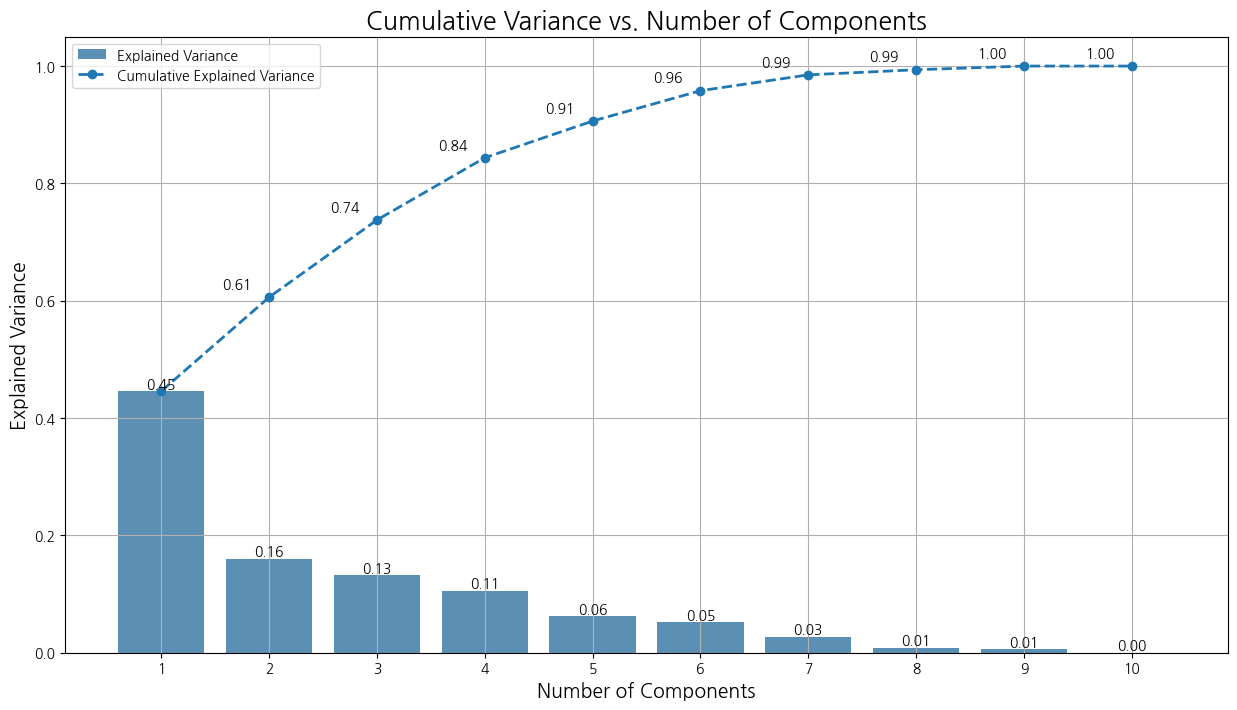

In [ ]:
plt.figure(figsize=(15, 8)) 

# 각 성분의 설명된 분포에 대한 막대 그래프
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)), y=explained_variance_ratio, alpha=0.8)

# 누적 분포에 대한 선 그래프
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance, marker='o', linestyle='--', linewidth=2)

# 레이블과 제목 설정
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# 눈금 및 범례 사용자 정의
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot],
           labels=['Explained Variance', 'Cumulative Explained Variance'])  

# 두 그래프의 분산 값 표시
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

In [16]:
# 6개의 주성분을 유지하는 PCA 선언 
pca = PCA(n_components=6)

# 기존 data를 pca에 fit_transform
data_pca = pca.fit_transform(data)

# 압축된 데이터 셋 생성
data_pca = pd.DataFrame(data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# 인덱스로 빼 두었던 CustomerID 다시 추가
data_pca.index = data.index

In [17]:
data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
16765,-2.174674,-0.439816,-0.042456,1.572851,0.644472,-0.199215
16148,-2.186834,-0.019528,0.584170,1.901838,0.662715,0.446327
15510,-2.406779,1.643639,3.048048,3.365739,0.958588,3.177294
14576,-2.340856,-0.477843,-0.092191,2.103430,1.172927,-0.335370
14424,-1.769715,2.564845,4.390853,1.808741,-1.147236,4.934680


# K-Means 클러스터링

In [20]:
# k=3개의 클러스터로 K-Means 클러스터링 적용
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(data_pca)

# 각 클러스터의 빈도수 구하기
cluster_frequencies = Counter(kmeans.labels_) 

# 빈도수에 기반하여 이전 레이블에서 새 레이블로의 매핑 생성
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

# 매핑을 적용하여 새 레이블 얻기
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# 원래 데이터셋에 새 클러스터 레이블 추가
user_data['cluster'] = new_labels

# PCA 버전의 데이터셋에 새 클러스터 레이블 추가
data_pca['cluster'] = new_labels

In [21]:
# K-Means 분류된 결과 보기
user_data.head()

,CustomerID,purchase_cnt,item_cnt,recency,user_total,user_average,unique_products,average_interval,total_transactions,cancel_frequency,cancel_rate,cluster
0,16765,1,4,294,34.0,34.0,1,0.0,1,0,0.0,0
1,16148,1,72,296,76.3,76.3,1,0.0,1,0,0.0,0
2,15510,1,2,330,250.0,250.0,1,0.0,1,0,0.0,0
3,14576,1,12,372,35.4,35.4,1,0.0,1,0,0.0,0
4,14424,1,48,17,322.1,322.1,1,0.0,1,0,0.0,0


In [22]:
user_data.value_counts('cluster')

cluster
0    3039
1     581
2     504
Name: count, dtype: int64

# 5. 시각화 및 결과 분석

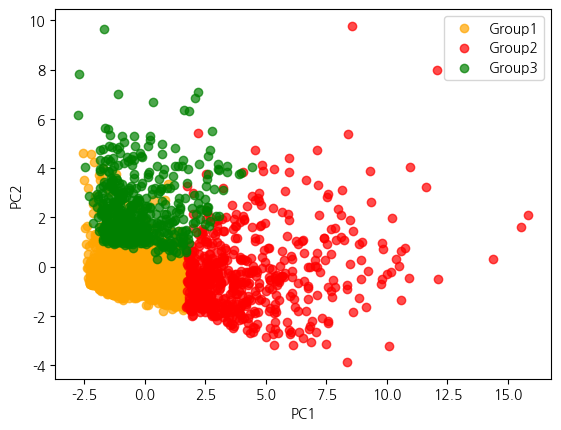

In [23]:
# 각 클러스터 별 데이터 분리 
cluster_0 = data_pca[data_pca['cluster'] == 0]
cluster_1 = data_pca[data_pca['cluster'] == 1]
cluster_2 = data_pca[data_pca['cluster'] == 2]


# 클러스터 별 시각화
plt.scatter(cluster_0['PC1'], cluster_0['PC2'], color = 'orange', alpha = 0.7, label = 'Group1')
plt.scatter(cluster_1['PC1'], cluster_1['PC2'], color = 'red', alpha = 0.7, label = 'Group2')
plt.scatter(cluster_2['PC1'], cluster_2['PC2'], color = 'green', alpha = 0.7, label = 'Group3')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

In [24]:
# 색상 지정 
colors = ['red', 'blue', 'green']

# 각 클러스터별 데이터 분릴
cluster_0 = data_pca[data_pca['cluster'] == 0]
cluster_1 = data_pca[data_pca['cluster'] == 1]
cluster_2 = data_pca[data_pca['cluster'] == 2]

# 3D Scatter Plot 생성
import plotly.graph_objects as go
fig = go.Figure()

# 각 클러스터별 데이터 표기 
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Group 1'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Group 2'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Group 3'))

# 범례 및 제목 영역 설정
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="grey", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="grey", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="grey", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

fig.show()

In [25]:
group1 = user_data[user_data['cluster'] == 0]
group2 = user_data[user_data['cluster'] == 1]
group3 = user_data[user_data['cluster'] == 2]

In [26]:
group1.describe()

,CustomerID,purchase_cnt,item_cnt,recency,user_total,user_average,unique_products,average_interval,total_transactions,cancel_frequency,cancel_rate,cluster
count,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.0
mean,15327.740375,45.440935,441.866403,107.275090,730.195393,23.891807,38.995064,1.930625,45.440935,0.272458,0.461404,0.0
std,1717.310423,38.687141,476.230951,104.081854,737.777340,37.484701,31.452017,2.859411,38.687141,0.703234,1.227093,0.0
min,12348.000000,1.000000,1.000000,0.000000,3.800000,2.070000,1.000000,0.000000,1.000000,0.000000,0.000000,0.0
25%,13827.500000,15.000000,132.000000,24.000000,240.400000,11.295000,15.000000,0.000000,15.000000,0.000000,0.000000,0.0
50%,15341.000000,33.000000,280.000000,64.000000,479.600000,16.680000,30.000000,0.560000,33.000000,0.000000,0.000000,0.0
75%,16805.500000,66.000000,578.000000,175.500000,962.950000,22.390000,56.000000,2.870000,66.000000,0.000000,0.000000,0.0
max,18287.000000,202.000000,6481.000000,373.000000,7829.900000,550.800000,161.000000,18.630000,202.000000,5.000000,9.090909,0.0


In [27]:
group2.describe()

,CustomerID,purchase_cnt,item_cnt,recency,user_total,user_average,unique_products,average_interval,total_transactions,cancel_frequency,cancel_rate,cluster
count,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.0
mean,15258.352840,250.609294,2631.113597,25.123924,4418.257659,22.847797,159.475043,1.294303,250.609294,3.822719,1.635405,1.0
std,1745.094767,112.670884,2003.223054,37.102725,3459.377332,35.776209,63.685662,0.898743,112.670884,4.746095,2.023348,0.0
min,12347.000000,16.000000,265.000000,0.000000,578.600000,2.570000,13.000000,0.000000,16.000000,0.000000,0.000000,1.0
25%,13756.000000,172.000000,1359.000000,4.000000,2299.700000,8.880000,116.000000,0.780000,172.000000,0.000000,0.000000,1.0
50%,15228.000000,221.000000,2054.000000,14.000000,3427.800000,16.700000,153.000000,1.180000,221.000000,2.000000,0.882353,1.0
75%,16771.000000,306.000000,3248.000000,31.000000,5313.000000,21.560000,201.000000,1.640000,306.000000,6.000000,2.575107,1.0
max,18283.000000,741.000000,14652.000000,315.000000,25758.100000,503.720000,317.000000,11.030000,741.000000,22.000000,10.666667,1.0


In [28]:
group3.describe()

,CustomerID,purchase_cnt,item_cnt,recency,user_total,user_average,unique_products,average_interval,total_transactions,cancel_frequency,cancel_rate,cluster
count,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.0
mean,15188.244048,44.515873,576.672619,78.172619,1038.073214,35.056429,32.676587,7.834683,44.515873,4.182540,9.424747,2.0
std,1698.593450,38.536700,692.408987,89.053115,1054.377744,57.631570,26.778165,8.885936,38.536700,4.347529,6.404458,0.0
min,12352.000000,2.000000,-303.000000,0.000000,-95.900000,-3.090000,1.000000,0.000000,2.000000,0.000000,0.000000,2.0
25%,13753.500000,16.000000,160.000000,15.000000,332.100000,14.435000,12.000000,2.017500,16.000000,1.000000,5.492077,2.0
50%,15202.500000,30.500000,359.500000,41.000000,676.200000,18.215000,24.000000,3.725000,30.500000,3.000000,8.377193,2.0
75%,16604.250000,63.250000,747.250000,107.750000,1402.500000,28.507500,47.000000,10.812500,63.250000,5.000000,12.500000,2.0
max,18282.000000,194.000000,9322.000000,366.000000,7312.800000,563.000000,128.000000,36.500000,194.000000,23.000000,31.250000,2.0
